In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv("../data/cleaned.csv")
df.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104


## Matching based on propensity score

In [5]:
df_rf = df.copy()
cat_vars = ["SEX", "RACE", "MARST", "EDUC", "STATEFIP", "OCC", "IND"]
X = pd.get_dummies(df_rf[["AGE", "YEARS_IN_US"] + cat_vars], drop_first=True)
T = df_rf["CITIZEN"].values
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    random_state=0,
    n_jobs=-1
)
rf.fit(X, T)
df_rf["e_hat"] = rf.predict_proba(X)[:, 1]
df_rf["e_hat"] = df_rf["e_hat"].clip(0.01, 0.99)
df_rf.head()

,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270
4,46,1,7,1,1,23,0,4230,7690,115.0,360.0,0,5.886104,0.304720


In [24]:
treated = df_rf[df_rf["CITIZEN"] == 1].copy()
control = df_rf[df_rf["CITIZEN"] == 0].copy()

print(len(treated), "treated; ", len(control), "controls")

ps_sd = df_rf["e_hat"].std()
caliper = 0.2 * ps_sd # 0.2 recommended by NIH https://pubmed.ncbi.nlm.nih.gov/20925139/
print("Caliper:", caliper)

nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto")
nbrs.fit(control[["e_hat"]])

dist, idx = nbrs.kneighbors(treated[["e_hat"]])

dist = dist.flatten()
idx = idx.flatten()

within_caliper_mask = dist <= caliper

matched_treated = treated[within_caliper_mask].reset_index(drop=True)
matched_control = control.iloc[idx[within_caliper_mask]].reset_index(drop=True)
pair_id = range(len(matched_treated))

matched_treated["pair_id"] = pair_id
matched_control["pair_id"] = pair_id

df_matched = pd.concat([matched_treated, matched_control], axis=0, ignore_index=True)

df_matched["CITIZEN"].value_counts()
df_matched.head()

123895 treated;  99903 controls
Caliper: 0.04380016007267966


,AGE,SEX,RACE,MARST,STATEFIP,YEARS_IN_US,EDUC,OCC,IND,PERWT,INCWAGE,CITIZEN,INCWAGE_LOG,e_hat,pair_id
0,49,2,6,6,1,47,6,8800,3470,5.0,7000.0,1,8.853665,0.690837,0
1,49,2,6,6,1,47,6,8800,3470,36.0,7000.0,1,8.853665,0.690837,1
2,49,2,6,6,1,47,6,8800,3470,38.0,7000.0,1,8.853665,0.690837,2
3,53,2,7,1,1,43,3,9600,6390,108.0,37400.0,1,10.529426,0.505270,3
4,51,1,7,6,1,31,7,440,7380,62.0,24000.0,1,10.085809,0.642700,4


''

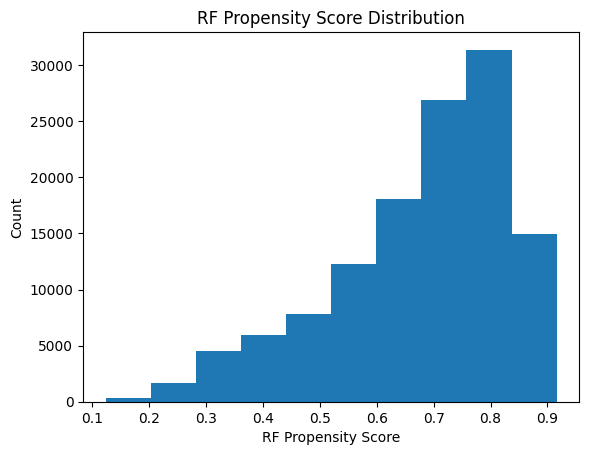

In [ ]:
plt.hist(df_matched['e_hat'])
plt.xlabel('RF Propensity Score')
plt.ylabel('Count')
plt.title('RF Propensity Score Distribution')
;

In [8]:
mod = smf.ols("INCWAGE_LOG ~ CITIZEN", data=df_matched).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:            INCWAGE_LOG   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           2.78e-29
Time:                        19:21:43   Log-Likelihood:            -3.6583e+05
No. Observations:              247790   AIC:                         7.317e+05
Df Residuals:                  247788   BIC:                         7.317e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8155      0.003   3594.399      0.0

In [21]:
tau_hat = 0.0478
perc = 100 * (np.exp(tau_hat) - 1)
print(perc)

4.896084217541996


## 1:M Matching

In [28]:
M = 5

In [57]:
treated_ = treated.reset_index(drop=True).copy()
control_ = control.reset_index(drop=True).copy()

nbrsM = NearestNeighbors(n_neighbors=M, algorithm="auto")
nbrsM.fit(control[["e_hat"]])

dist, idx = nbrsM.kneighbors(treated[["e_hat"]])

In [65]:
covars = ["AGE", "YEARS_IN_US", "SEX", "RACE", "MARST",
          "STATEFIP", "EDUC", "OCC", "IND"]
formula0 = "INCWAGE_LOG ~ " + " + ".join(covars)
mu0_model = smf.ols(formula0, data=control).fit()
mu0_treated = mu0_model.predict(treated_[covars]).to_numpy()
mu0_control = mu0_model.predict(control_[covars]).to_numpy()

In [72]:
mu0_i = mu0_treated[:, None]
mu0_k = mu0_control[idx]

assert len(mu0_i) == len(mu0_k)

In [77]:
B_i = (mu0_i - mu0_k).mean(axis=1)
bias_hat = B_i.mean()

print("Estimated bias:", bias_hat)

Y_t = treated_["INCWAGE_LOG"].to_numpy()
Y_c = control_["INCWAGE_LOG"].to_numpy()
Y_c_matched = Y_c[idx]
Y_c_bar_i = Y_c_matched.mean(axis=1)
ATT_match = np.mean(Y_t - Y_c_bar_i)

print("Naive matching ATT:", ATT_match)

ATT_bc = ATT_match - bias_hat

print("Bias-corrected ATT:", ATT_bc)

Estimated bias: 0.012629788921126582
Naive matching ATT: 0.058156539595015974
Bias-corrected ATT: 0.04552675067388939


In [78]:
perc = 100 * (np.exp(ATT_bc) - 1)
print(perc)

4.657900093304024
